In [ ]:
!pip install open_clip_torch

In [ ]:
import requests
import os

# Головные убора
HATS = [
    "https://odezhda.guru/wp-content/uploads/2019/07/1-130.jpg",
    "https://www.100suvenirov.ru/data/Image/catalog/504335-shapka-real-talk-golubaya_bb.jpg",
    "https://cat.rk-a.ru/files/catalog/2/th/400/c8/a9/c8a9a14a14411077a223c25b1a62a5cb.jpg",
]

# Верхняя одежда
TOP = [
    "https://gas-kvas.com/uploads/posts/2023-01/1673554162_gas-kvas-com-p-detskaya-futbolka-chernaya-bez-risunka-17.jpg",
    "https://vispo.ru/upload/iblock/e8d/w302kom0ajlqcq6g9jabldwdkevltnku/02102220_1_tif_1000x1000.jpg",
    "https://i.pinimg.com/originals/e0/63/4a/e0634a9b331217bab3c44abf7a1d8866.jpg",
]

# Штаны
PANTS = [
    "https://cdn1.ozone.ru/s3/multimedia-l/6755030049.jpg",
    "https://fashionhot.club/uploads/posts/2022-11/thumbs/1669049646_67-fashionhot-club-p-shirokie-klassicheskie-bryuki-71.jpg",
    "https://img.fantaskycdn.com/f2d5188c17096157613a8757bc2ec240.jpeg",
]

# Обувь
SHOES = [
    "https://obuv.expert/wp-content/uploads/2019/04/slipony-zhenskie-iz-naturalnogo-zamsha-svetlo-serogo-cveta-na-beloy-podoshve-kollekci-1519-1920x1440-1024x768.jpg",
    "https://img.klubok.com/img/used/2018/04/13/16986/l/16986489_2.jpg",
    "https://www.coolthings.com/wp-content/uploads/2023/09/crocs-classic-dreamworks-shrek-clogs-1.jpg",
]

# Ссылки для скачивания
ITEMS = {
    "hats": HATS,
    "top": TOP,
    "pants": PANTS,
    "shoes": SHOES,
}


def download_images_from_urls(urls, output_dir):
    """
    Downloads images from a list of URLs.

    Args:
        urls (list): A list of image URLs.
        output_dir (str): The directory to save the downloaded images.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, url in enumerate(urls):
        try:
            img_data = requests.get(url).content
            filename = os.path.join(output_dir, f"{i}.jpg")
            with open(filename, 'wb') as handler:
                handler.write(img_data)
            print(f"Downloaded: {filename}")
        except Exception as e:
            print(f"Could not download {url}: {e}")

# Download images for each item type in ITEMS
for item_type, urls in ITEMS.items():
    download_images_from_urls(urls, item_type)

Downloaded: hats/0.jpg
Downloaded: hats/1.jpg
Downloaded: hats/2.jpg
Downloaded: top/0.jpg
Downloaded: top/1.jpg
Downloaded: top/2.jpg
Downloaded: pants/0.jpg
Downloaded: pants/1.jpg
Downloaded: pants/2.jpg
Downloaded: shoes/0.jpg
Downloaded: shoes/1.jpg
Downloaded: shoes/2.jpg


In [ ]:
import open_clip
import torch
from PIL import Image
import os

# Load the CLIP model and processor
# Using a model and checkpoint that are compatible with Stable Diffusion
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

# Set the model to evaluation mode
model.eval()

embeddings = dict()

# Function to get image embeddings
def get_image_embedding(image_path):
    """
    Generates CLIP embedding for an image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        torch.Tensor: The image embedding.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        image = preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_features = model.encode_image(image)
        return image_features
    except Exception as e:
        print(f"Could not process image {image_path}: {e}")
        return None

# Iterate through the downloaded image folders and generate embeddings
image_folders = ["hats", "top", "pants", "shoes"]
for folder in image_folders:
    if os.path.exists(folder):
        print(f"Processing images in folder: {folder}")
        folder_embeddings = dict()
        for filename in os.listdir(folder):
            if filename.endswith(".jpg"):
                image_path = os.path.join(folder, filename)
                embedding = get_image_embedding(image_path)
                if embedding is not None:
                    folder_embeddings[image_path] = embedding.squeeze()
        embeddings[folder] = folder_embeddings
    else:
        print(f"Folder not found: {folder}")

# You can now access the embeddings in the 'embeddings' dictionary
# For example, to access the embeddings for hats: embeddings['hats']
# To access the embedding for a specific image: embeddings['hats']['hats/0.jpg']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Processing images in folder: hats
Processing images in folder: top
Processing images in folder: pants
Processing images in folder: shoes


In [ ]:
!pip install qdrant-client

In [ ]:
from qdrant_client import QdrantClient
import qdrant_client.http.models
from qdrant_client.http.models import PointStruct

client = QdrantClient(path="qdrant.db")

In [ ]:
existing_collections = client.get_collections().collections
existing_collection_names = [collection.name for collection in existing_collections]

for category, category_embeddings in embeddings.items():
    print(f"Processing category: {category}")

    if category in existing_collection_names:
        print(f"Collection '{category}' already exists. Skipping creation and population.")
    else:
        print(f"Collection '{category}' does not exist. Proceeding with creation and population.")
        vector_size = list(category_embeddings.values())[0].shape[0]
        client.recreate_collection(
            collection_name=category,
            vectors_config=qdrant_client.http.models.VectorParams(size=vector_size, distance=qdrant_client.http.models.Distance.COSINE)
        )
        print(f"Collection '{category}' created.")

        points_to_upload = []
        for image_path, embedding in category_embeddings.items():
            point_id = hash(image_path) # Generate a simple hash as point ID
            points_to_upload.append(PointStruct(id=point_id, vector=embedding.tolist(), payload={"image_path": image_path}))

        if points_to_upload:
            client.upsert(
                collection_name=category,
                wait=True,
                points=points_to_upload
            )
            print(f"Uploaded {len(points_to_upload)} points to collection '{category}'.")


Processing category: hats
Collection 'hats' does not exist. Proceeding with creation and population.
Collection 'hats' created.
Uploaded 3 points to collection 'hats'.
Processing category: top
Collection 'top' does not exist. Proceeding with creation and population.
Collection 'top' created.
Uploaded 3 points to collection 'top'.
Processing category: pants
Collection 'pants' does not exist. Proceeding with creation and population.
Collection 'pants' created.
Uploaded 3 points to collection 'pants'.
Processing category: shoes
Collection 'shoes' does not exist. Proceeding with creation and population.
Collection 'shoes' created.


/tmp/ipython-input-3336271868.py:12: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Uploaded 3 points to collection 'shoes'.



Searching for 'A hat like Cartman's from South Park' in 'hats' category:
Found image: hats/2.jpg (Score: 0.2992)


/tmp/ipython-input-3609230879.py:47: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


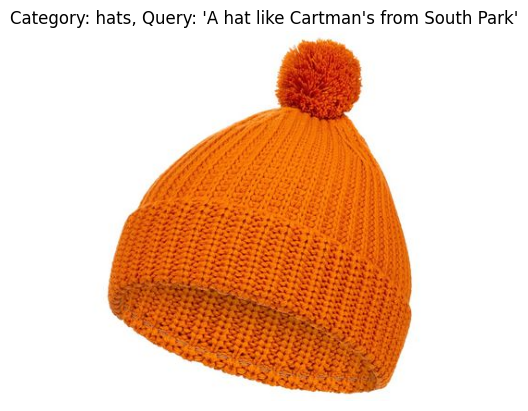


Searching for 'gray pants' in 'pants' category:
Found image: pants/0.jpg (Score: 0.2844)


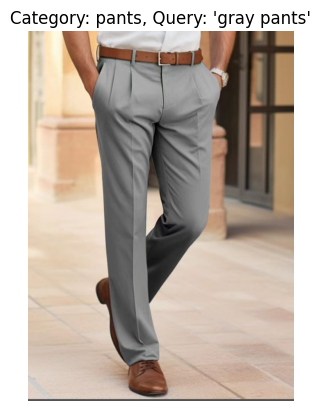


Searching for 'slip-ons' in 'shoes' category:
Found image: shoes/1.jpg (Score: 0.2975)


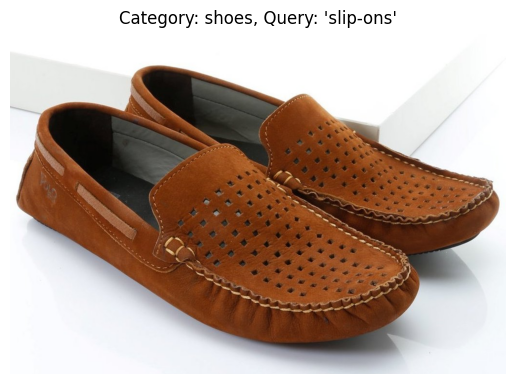


Searching for 'kimono' in 'top' category:
Found image: top/2.jpg (Score: 0.2268)


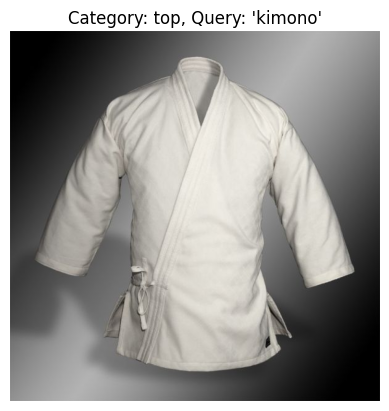

In [ ]:
PROMTS = {
    "hats": "A hat like Cartman's from South Park",
    "pants": "gray pants",
    "shoes": "slip-ons",
    "top": "kimono",
}

import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

# Function to get text embedding
def get_text_embedding(text):
    """
    Generates CLIP embedding for a text query.

    Args:
        text (str): The text query.

    Returns:
        torch.Tensor: The text embedding.
    """
    try:
        text_tokenized = open_clip.tokenize(text)
        with torch.no_grad():
            text_features = model.encode_text(text_tokenized)
        return text_features
    except Exception as e:
        print(f"Could not process text query '{text}': {e}")
        return None

# Function to search Qdrant
def search_qdrant(collection_name, query_embedding, top_k=1):
    """
    Searches a Qdrant collection for similar vectors.

    Args:
        collection_name (str): The name of the Qdrant collection.
        query_embedding (list): The query vector (text or image embedding).
        top_k (int): The number of top results to return.

    Returns:
        list: A list of search results.
    """
    try:
        search_result = client.search(
            collection_name=collection_name,
            query_vector=query_embedding,
            limit=top_k
        )
        return search_result
    except Exception as e:
        print(f"Error during Qdrant search in collection '{collection_name}': {e}")
        return []

# Search and display results for each category
for category, prompt in PROMTS.items():
    print(f"\nSearching for '{prompt}' in '{category}' category:")
    text_embedding = get_text_embedding(prompt)

    if text_embedding is not None:
        # Convert tensor to list for Qdrant search
        query_vector = text_embedding.squeeze().tolist()
        search_results = search_qdrant(category, query_vector, top_k=1)

        if search_results:
            for result in search_results:
                image_path = result.payload["image_path"]
                print(f"Found image: {image_path} (Score: {result.score:.4f})")
                try:
                    img = Image.open(image_path)
                    plt.imshow(img)
                    plt.title(f"Category: {category}, Query: '{prompt}'")
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Could not display image {image_path}: {e}")
        else:
            print(f"No results found for query '{prompt}' in category '{category}'.")